This notebook demonstrates various dimensionality reduction techniques for visualizing high-dimensional data.


In [62]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# import the data from all sheets of the Excel file

df0 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=0)
df1 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=1)
df2 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=2)
df3 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=3)

# Concatenate all sheets into a single DataFrame
df = pd.concat([df0, df1, df2, df3], ignore_index=True)

In [63]:
# Custom style for academic/research plots with vivid colors

# Configure matplotlib to use LaTeX fonts
plt.rcParams.update({
    # Font settings - LaTeX style
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    
    
    # Grid settings - darker and more visible
    'grid.alpha': 0.6,
    'grid.color': '#2a2a2a',
    'grid.linewidth': 0.6,
    'grid.linestyle': '-',
    
    # Axes settings
    'axes.grid': True,
    'axes.linewidth': 1.2,
    'axes.edgecolor': '#333333',
    'axes.labelweight': 'normal',
    
    # Figure settings
    'figure.facecolor': 'white',
    'axes.facecolor': '#fafafa',
    
    # Line settings
    'lines.linewidth': 2,
    'lines.markersize': 6,
    
    # Legend settings
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.fancybox': False,
    'legend.edgecolor': '#333333',
})

# Vivid color palette (strong, saturated colors)
vivid_colors = [
    '#E63946',  # Vivid Red
    '#1D3557',  # Navy Blue
    '#2A9D8F',  # Teal
    '#F77F00',  # Orange
    '#8338EC',  # Purple
    '#06D6A0',  # Mint Green
    '#FFB703',  # Yellow
    '#C1121F',  # Dark Red
    '#0353A4',  # Blue
    '#B5179E',  # Magenta
]

# Set the color cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=vivid_colors)

# Seaborn integration
sns.set_palette(vivid_colors)
sns.set_style("whitegrid", {
    'grid.color': '#2a2a2a',
    'grid.alpha': 0.6,
    'grid.linewidth': 0.6,
})


For the dataset used, the best results are achieved with **PCA** and **t-SNE**. However, the optimal method may vary depending on the specific dataset and analysis objectives. The primary technique selected is **PCA**.

### Overview of PCA
Principal Component Analysis (PCA) is a dimensionality reduction technique that:
- Identifies the directions (principal components) along which the data exhibits the most variance.
- Projects the data onto these components, reducing the number of dimensions while preserving most of the variance.

This process simplifies the dataset, facilitating visualization and analysis while retaining essential patterns and structures. Note that PCA transforms the data into a new set of features (principal components), meaning the original features are not directly recoverable.

In [64]:
# Correct PCA implementation
pca = PCA(n_components=2)

# The wavelength columns are from index 3 to the end
wavelength_data = df.iloc[:, 3:]

# Fit AND transform the data
pca_components = pca.fit_transform(wavelength_data)

# Check explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")
print(f"Total explained variance: {explained_variance.sum():.2%}")

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_components,
    columns=['PC1', 'PC2']
)


# Add categorical columns for plotting
pca_df['Tratamiento'] = df['Tratamiento'].values
pca_df['Planta'] = df['Planta'].values

# Reorder columns to put Tratamiento and Planta first
pca_df = pca_df[['Tratamiento', 'Planta', 'PC1', 'PC2']]

pca_df.shape

Explained variance by PC1: 61.88%
Explained variance by PC2: 23.21%
Total explained variance: 85.09%


(955, 4)

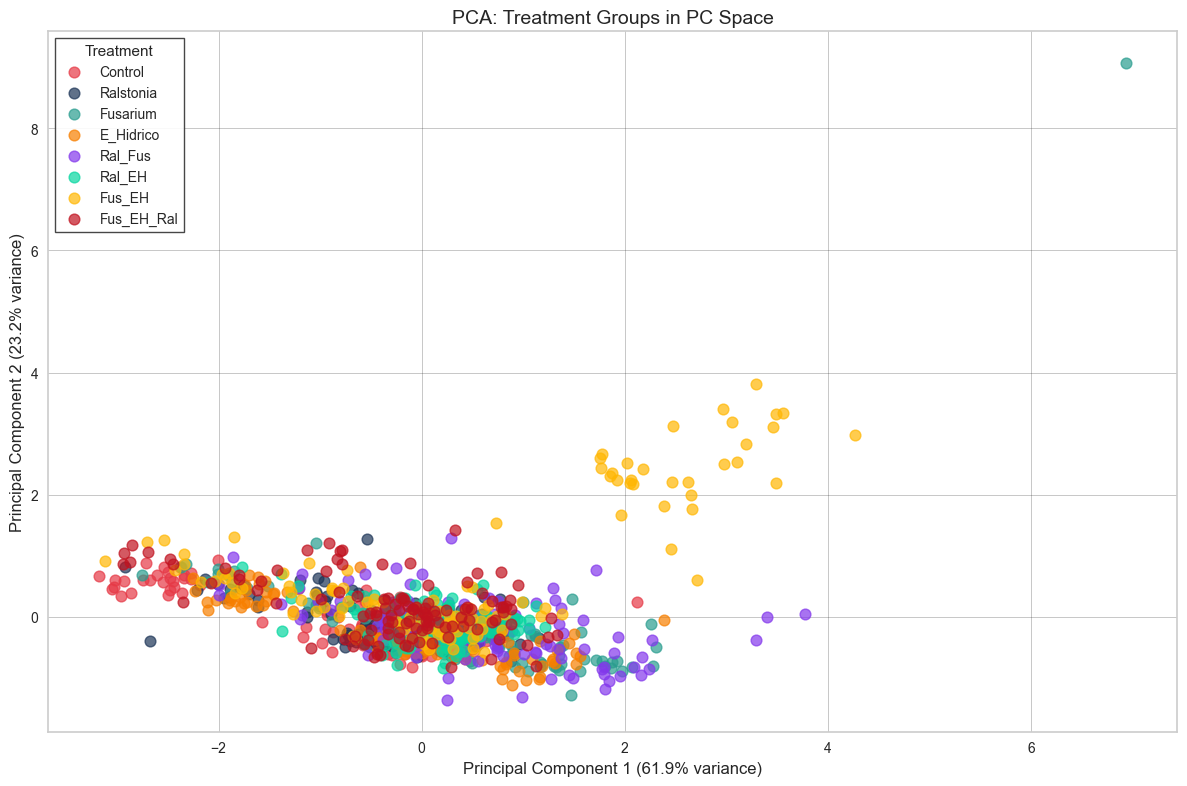

In [65]:
# Direct PCA visualization approach (without using template)
plt.figure(figsize=(12, 8))

# Plot each treatment as a separate group
for treatment in pca_df['Tratamiento'].unique():
    subset = pca_df[pca_df['Tratamiento'] == treatment]
    plt.scatter(subset['PC1'], subset['PC2'], 
                label=treatment, alpha=0.7, s=60)

# Add proper labels that reflect PCA meaning
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.1%} variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.1%} variance)')
plt.title('PCA: Treatment Groups in PC Space')
plt.legend(title='Treatment')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


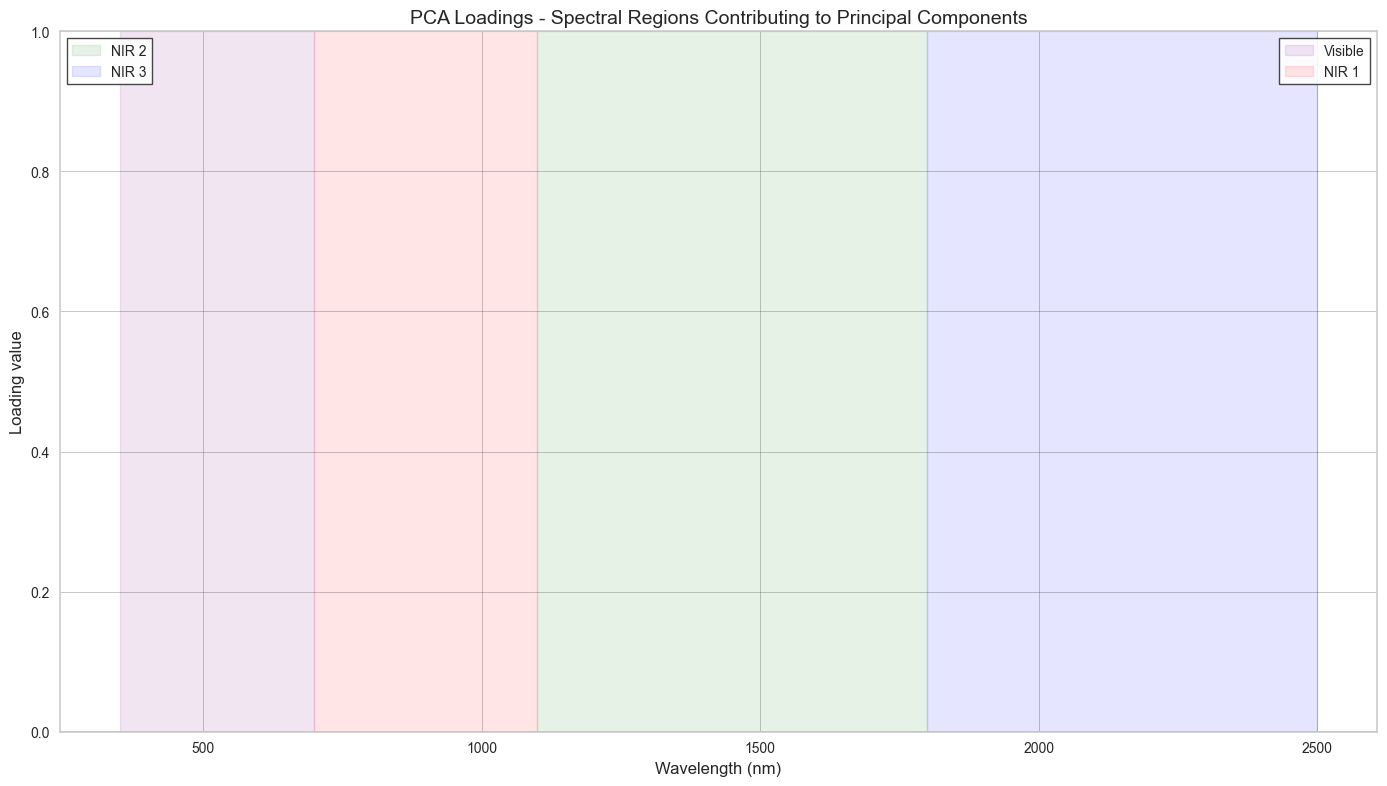

In [66]:
# Get the loadings for the first two principal components
loadings = pca.components_

# Create a plot
fig, ax = plt.subplots(figsize=(14, 8))


# Add labels and title
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('Loading value', fontsize=12)
ax.set_title('PCA Loadings - Spectral Regions Contributing to Principal Components', fontsize=14)

# Add a horizontal line at y=0 for reference
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Add shaded regions for different spectral ranges
ax.axvspan(350, 700, alpha=0.1, color='purple', label='Visible')
ax.axvspan(700, 1100, alpha=0.1, color='red', label='NIR 1')
ax.axvspan(1100, 1800, alpha=0.1, color='green', label='NIR 2')
ax.axvspan(1800, 2500, alpha=0.1, color='blue', label='NIR 3')

# Create custom legends
# First legend for PC1 and PC2
handles1, labels1 = ax.get_legend_handles_labels()
leg1 = ax.legend(handles1[:2], labels1[:2], loc='upper right', fontsize=10)
ax.add_artist(leg1)

# Second legend for spectral regions
handles2, labels2 = ax.get_legend_handles_labels()
ax.legend(handles2[2:], labels2[2:], loc='upper left', fontsize=10)

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Understanding PCA Outputs: `pca.components_` vs `pca.fit_transform()`

These two outputs serve **completely different purposes** in PCA analysis. Here's a detailed explanation:

---

### 1. **`pca.components_`** - The Transformation Matrix (Loadings)

#### What it is:
The **principal component vectors** that define the new coordinate system.

#### Dimensions:


In [67]:
pca.components_.shape
# Output: (n_components, n_features)
# → 2 rows (PC1, PC2) × ~2150 columns (wavelengths)

(2, 2150)



#### What it contains:
- **Each ROW** = One principal component (PC1, PC2)
- **Each COLUMN** = Weight for one original feature (wavelength)
- **Values** = How much each wavelength contributes to that PC

#### Interpretation:


In [68]:
loadings = pca.components_
print(loadings[0, 500])  # How much wavelength #500 contributes to PC1
print(loadings[1, 1000]) # How much wavelength #1000 contributes to PC2

0.032051193208525126
-0.0076217003322666625




This tells you **which features (wavelengths) are important** for each component.

---

### 2. **`pca.fit_transform()`** - The Transformed Data (Scores)

#### What it is:
Your **original data projected** onto the new principal component axes.

#### Dimensions:


In [69]:
pca_components = pca.fit_transform(wavelength_data)
pca_components.shape
# Output: (n_samples, n_components)
# → Same number of rows as original data × 2 columns (PC1, PC2)

(955, 2)



### What it contains:
- **Each ROW** = One sample (one plant measurement)
- **Each COLUMN** = The sample's coordinate along one PC
- **Values** = Where each plant sits in the reduced 2D space

### Interpretation:


In [70]:
print(pca_components[0, 0])  # Plant #0's position on PC1
print(pca_components[0, 1])  # Plant #0's position on PC2

0.013891787208820259
-0.3037504251173571




This is what you **plot as scatter points** to visualize sample relationships.

---

### Why the Dimension Difference?

#### Mathematical Relationship:

Original data:        (n_samples, n_features)  → (plants, wavelengths)

Components (weights): (n_components, n_features) → (2 PCs, wavelengths)

Transformed (scores): (n_samples, n_components) → (plants, 2 PCs)




---

## Guide to Differences

| Attribute | `pca.components_` | `pca.fit_transform()` |
|-----------|-------------------|----------------------|
| **Purpose** | How to transform data | Transformed data itself |
| **Shape** | (2, 2150+) | (N_plants, 2) |
| **Rows represent** | Principal components | Individual samples |
| **Columns represent** | Original wavelengths | Principal components |
| **Used for** | Understanding feature importance | Visualization & analysis |
| **Plotting** | Line plot (loadings vs wavelength) | Scatter plot (PC1 vs PC2) |

---

## Key Insight

- **`pca.components_`** stays the same size as your **original features** because it describes how those features combine to form PCs
- **`pca.fit_transform()`** stays the same size as your **original samples** because each sample gets a new coordinate in PC space

The number of **rows** is preserved (samples), but **columns** are reduced (from 2150 wavelengths → 2 PCs).

# Plot PCA results
we found some interesting patterns and important insights on the data:
1. This means PCA has identified it as the most spectrally unique sample in your entire dataset. It shares very little in common with any other plant, including those from other combined stress treatments, take a look at the point in the top right corner of the PCA plot, which is a plant that was exposed to Fusarium.

What does this mean for the analysis?
Theres two possiblities for this point being so far away from all other points:
- **A Measurement Error:** It's possible this is a bad measurement. The instrument could have had an error, or there might have been an issue with that specific plant sample.
- **A Truly Unique Spectral Signature:** If the measurement is accurate, this spectral signature is genuinely different from all others. This could indicate a unique physiological response to the Fusarium treatment, making it an outlier in terms of its spectral characteristics.

2. The second most unique reaction to the treatments is the plant that was exposed to both Fusarium and drought, located in the center right of the PCA plot. This plant is also quite far away from all other plants, indicating that the combined stress treatment caused a very different spectral response compared to all other treatments.

It's important to note that PCA does not directly indicate which specific wavelengths are responsible for these differences. To identify the key wavelengths, further analysis is required, such as examining the loadings of the principal components or using other feature importance techniques.



# PCA with 3 components 


In [71]:
# Correct PCA implementation
pca = PCA(n_components=3)

# The wavelength columns are from index 3 to the end
wavelength_data = df.iloc[:, 3:]

# Fit AND transform the data
pca_components = pca.fit_transform(wavelength_data)

# Check explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")
print(f"Explained variance by PC3: {explained_variance[2]:.2%}")
print(f"Total explained variance: {explained_variance.sum():.2%}")

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_components,
    columns=['PC1', 'PC2', 'PC3']
)

# Add categorical columns for plotting
pca_df['Tratamiento'] = df['Tratamiento'].values
pca_df['Planta'] = df['Planta'].values

# Reorder columns to put Tratamiento and Planta first
pca_df = pca_df[['Tratamiento', 'Planta', 'PC1', 'PC2', 'PC3']]

Explained variance by PC1: 61.88%
Explained variance by PC2: 23.21%
Explained variance by PC3: 9.28%
Total explained variance: 94.38%


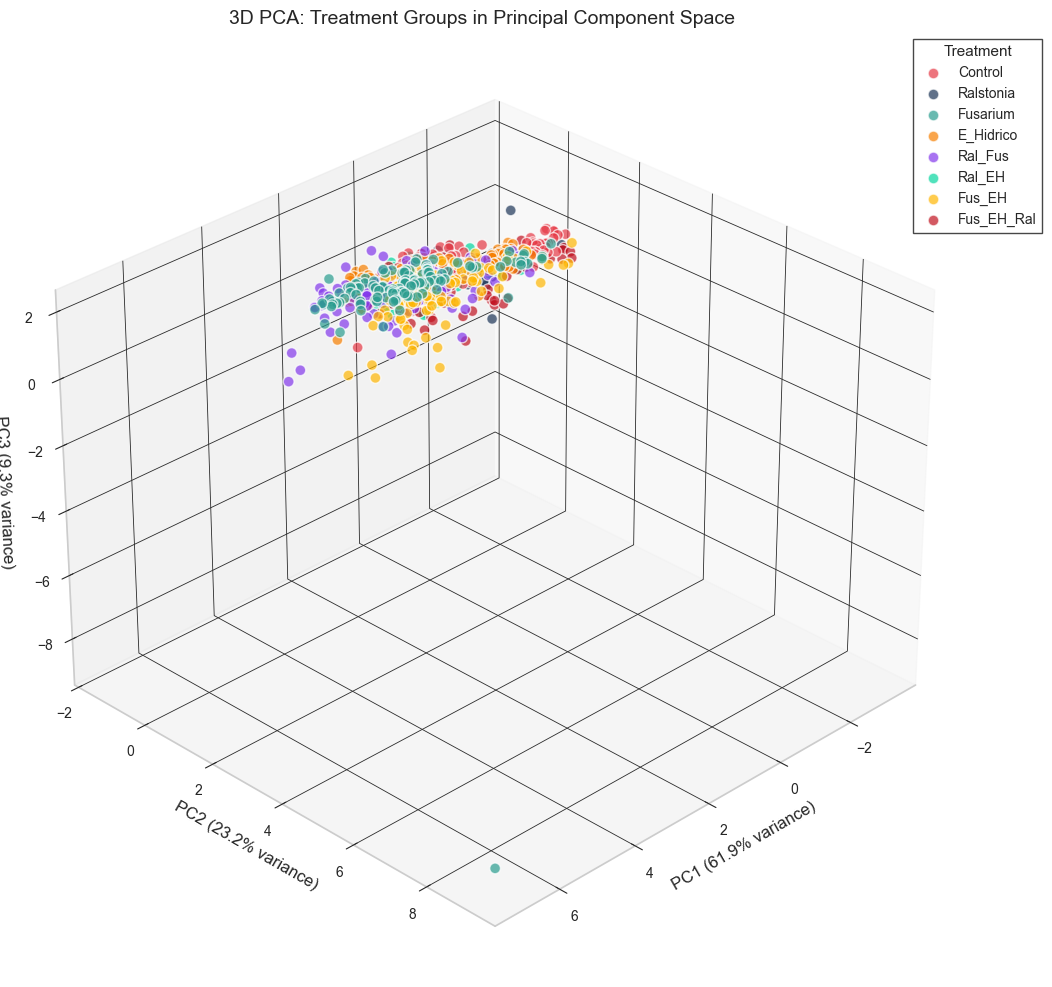

In [72]:
# Create a 3D scatter plot to visualize the PCA results

# Create the figure and 3D axes
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique treatments for color mapping
treatments = pca_df['Tratamiento'].unique()

# Plot each treatment group with a different color
for treatment in treatments:
    subset = pca_df[pca_df['Tratamiento'] == treatment]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
               label=treatment, alpha=0.7, s=60, edgecolor='w')

# Set axis labels with explained variance
ax.set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)', fontsize=12)
ax.set_zlabel(f'PC3 ({explained_variance[2]:.1%} variance)', fontsize=12)

# Set title and legend
ax.set_title('3D PCA: Treatment Groups in Principal Component Space', fontsize=14)
ax.legend(title='Treatment', loc='upper right', bbox_to_anchor=(1.1, 1))

# Improve perspective
ax.view_init(elev=30, azim=45)
ax.dist = 12

# Add grid for better depth perception
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: Interactive rotation
def rotate_plot():
    for angle in range(0, 360, 10):
        ax.view_init(30, angle)
        plt.draw()
        plt.pause(0.1)
        
# Uncomment to activate rotation
# rotate_plot()